In [1]:
# ! pip install networkx

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import networkx
import matplotlib.pyplot as plt
import re

In [3]:
zoo_folder = Path('/home/marek/pepr/Zoo/')

In [4]:
! ls {zoo_folder}/'cifar10'

dgms		      layout.csv   metrics.csv.gz
dgms_s77_c4_n144.npy  LICENSE	   README.md
head100_weights.npy   metrics.csv  weights.npy


In [5]:
DS = 'cifar10'
weights_path = zoo_folder.parent / 'Zoo_local' / 'weights.npy'; assert weights_path.exists()
layout_path = zoo_folder / DS / 'layout.csv'; assert layout_path.exists()

In [6]:
# B = networkx.Graph()
# B.add_nodes_from([1,2,3,4], bipartite=0) # Add the node attribute "bipartite"
# B.add_nodes_from(['abc','bcd','cef'], bipartite=1)
# B.add_edges_from([(1,'abc'), (1,'bcd'), (2,'bcd'), (2,'cef'), (3,'cef'), (4,'abc')] )

# top = networkx.bipartite.sets(B)[0]
# pos = networkx.bipartite_layout(B, top)
# networkx.draw(B, pos=pos, with_labels=True, node_color=['green','green','green','green','blue','blue','blue'])
# plt.show()

### Topology of the graph

In [7]:
lay = pd.read_csv(layout_path)
lay

,varname,start_idx,end_idx,size,shape
0,sequential/conv2d/bias:0,0,16,16,"(16,)"
1,sequential/conv2d/kernel:0,16,160,144,"(3, 3, 1, 16)"
2,sequential/conv2d_1/bias:0,160,176,16,"(16,)"
3,sequential/conv2d_1/kernel:0,176,2480,2304,"(3, 3, 16, 16)"
4,sequential/conv2d_2/bias:0,2480,2496,16,"(16,)"
5,sequential/conv2d_2/kernel:0,2496,4800,2304,"(3, 3, 16, 16)"
6,sequential/dense/bias:0,4800,4810,10,"(10,)"
7,sequential/dense/kernel:0,4810,4970,160,"(16, 10)"


In [8]:
metrics = pd.read_csv(layout_path.parent / f'metrics.csv')

In [9]:
ws2 = np.load(weights_path)
# ws = np.load(weights_path.parent / f'head100_{weights_path.name}')

In [10]:
ws = ws2[8::9]

In [11]:
ws.shape

(30000, 4970)

## Re-construct graph

In [12]:
inp_size = (32, 32)

def make_layer_vertices(n_channels, stride=1):
    return [ [[(h, w, c)
     for c in range(n_channels)]
     for h in range(inp_size[0]//stride)]
     for w in range(inp_size[1]//stride)]

def parse_shape(shape_str : str):
    return [int(x)
       for x in shape_str.strip(' )(').split(',')]

vertices = []
shapes = []
ixs = []
stride = 1
for i, row in lay.iterrows():
    if row.varname.endswith('kernel:0'):
        shape = parse_shape(row['shape'])
        shapes.append(shape)
        ixs.append([row.start_idx, row.end_idx])
        n_cs = shape[2] if len(shape) == 4 else shape[0]
        vs = make_layer_vertices(n_cs, stride)
        vertices.append(np.array(vs))
        stride *= 2

In [13]:
for vts in vertices:
    print(vts.shape[:-1])

(32, 32, 1)
(16, 16, 16)
(8, 8, 16)
(4, 4, 16)


### Construct edges (TODO)

In [14]:
# def make_edges(l1, l2, weight, kernel=[[-1,0,1]]*2):
#     """return list of edges"""
#     print(l1.shape, l2.shape)
#     w1, h1, c1 = l1.shape[:3]
#     w2, h2, c2 = l2.shape[:3]
#     stride = w1//w2
#     K = [len(k) for k in kernel]
#     weight = np.reshape(weight, K+[c1, c2])
    
#     print(stride)
    
#     for w_ in range(w2):
#         for h_ in range(h2):
#             for c1_ in range(c1):
#                 for c2_ in range(c2):
                    

    
# make_edges(vertices[0], vertices[1], weight=ws[0][16:160])

__Construct distance matrics from "implicit weights"__


i-th layer is nerve complex of nbs in the (i+1)-th layer 

In [15]:
I = 8+9
L = 1
S = 2 # stride

In [16]:
metrics.iloc[I]

Unnamed: 0                           /cns/ym-d/home/brain-ber/dnn_science/unterthin...
config.activation                                                                 tanh
config.b_init                                                                    zeros
config.dataset                                                                 cifar10
config.dnn_architecture                                                            cnn
config.dropout                                                                0.450656
config.epochs                                                                       86
config.epochs_between_checkpoints                                                   20
config.init_std                                                               0.002582
config.l2reg                                                                  0.000015
config.learning_rate                                                          0.001681
config.num_layers                          

In [17]:
from itertools import product
# def perprocess_kernel(weight, shape=shape):
#     weight = weight.reshape(shape)
#     weight = np.abs(weight)
#     w, h, ci, co = shape
#     kdist = np.zeros([w,h,ci, w,h,ci])
#     for w1, h1, ci1 in product(range(w), range(h), range(ci)):
#         for w2, h2, ci2 in product(range(w), range(h), range(ci)):
#             v = np.minimum(weight[w1,h1,ci1,:], weight[w2,h2,ci2,:])
# #             v = weight[w1,h1,ci1,:] + weight[w2,h2,ci2,:]
#             v = np.amax(v, axis=0)
#             kdist[w1,h1,ci1,w2,h2,ci2] = v
#     return kdist
    
# pker = perprocess_kernel(weight=ws[I][ixs[L][0]:ixs[L][1]], shape=shapes[L])
# pker.shape

In [18]:
# w,h,c = vertices[L].shape[:3]
# w = 6
# h = w
# dist = np.zeros([w+2,h+2,c,w+2,h+2,c])
# dist.shape

# for i1 in range(0, h, S):
#     for j1 in range(0, w, S):
#         for i2 in range(0, h, S):
#             for j2 in range(0, w, S):
#                 d = dist[i1:i1+3, j1:j1+3, :, i2:i2+3, j2:j2+3, :]
#                 v = np.maximum(d, pker)
#                 dist[i1:i1+3, j1:j1+3, :, i2:i2+3, j2:j2+3, :] = v
        
# dist = dist[1:-1, 1:-1, :, 1:-1, 1:-1, :].reshape([w*h*c, w*h*c])
# for i in range(w*h*c):
#     dist[i,i] = 0.
# dist.shape

In [19]:
# np.max(dist), np.min(dist)

In [20]:
# dist[0,0], dist[-1,-1]

In [21]:
# np.unique(dist)

In [22]:
# plt.imshow(dist[:,:,np.newaxis])

In [23]:
from gtda.homology import VietorisRipsPersistence

In [24]:
# vrp = VietorisRipsPersistence(
#     metric='precomputed', 
#     homology_dimensions=(0, 1, 2, 3))

# r = vrp.fit_transform_plot([dist])[0]

# np.unique(r, axis=0, return_counts=True)

In [25]:
def compute_dataset_dgms(I=0):
    def perprocess_kernel(weight, shape=shape):
        weight = weight.reshape(shape)
        weight = np.abs(weight)
        w, h, ci, co = shape
        kdist = np.zeros([w,h,ci, w,h,ci])
        for w1, h1, ci1 in product(range(w), range(h), range(ci)):
            for w2, h2, ci2 in product(range(w), range(h), range(ci)):
                v = np.minimum(weight[w1,h1,ci1,:], weight[w2,h2,ci2,:])
    #             v = weight[w1,h1,ci1,:] + weight[w2,h2,ci2,:]
                v = np.amax(v, axis=0)
                kdist[w1,h1,ci1,w2,h2,ci2] = v
        return kdist

    pker = perprocess_kernel(weight=ws[I][ixs[L][0]:ixs[L][1]], shape=shapes[L])
    
    w,h,c = vertices[L].shape[:3]
    w = 6
    h = w
    dist = np.zeros([w+2,h+2,c,w+2,h+2,c])

    for i1 in range(0, h, S):
        for j1 in range(0, w, S):
            for i2 in range(0, h, S):
                for j2 in range(0, w, S):
                    d = dist[i1:i1+3, j1:j1+3, :, i2:i2+3, j2:j2+3, :]
                    v = np.maximum(d, pker)
                    dist[i1:i1+3, j1:j1+3, :, i2:i2+3, j2:j2+3, :] = v

    dist = dist[1:-1, 1:-1, :, 1:-1, 1:-1, :].reshape([w*h*c, w*h*c])
    for i in range(w*h*c):
        dist[i,i] = 0.
    
    vrp = VietorisRipsPersistence(
        n_jobs=1,
        metric='precomputed', 
        homology_dimensions=(0, 1, 2)
    )

    r = vrp.fit_transform([dist])
    return np.unique(r, axis=1, return_counts=True)

# compute_dataset_dgms().shape

In [26]:
from tqdm import tqdm
from joblib import Parallel, delayed

In [27]:
cached_path = Path("cifar10_wt_udgms_l01.npz")
if not cached_path.exists():
    result = Parallel(n_jobs=5)(delayed(compute_dataset_dgms)(i) 
                   for i in tqdm(range(ws.shape[0])))


    max_counts = np.max([len(r[1]) for r in result])

    cnt = result[0][1]


cnt_pad = np.pad(cnt, (0, max_counts-cnt.shape[0]), 'constant', constant_values=(0, 0))
assert np.allclose(cnt_pad[:len(cnt)], cnt)
cnt_pad.shape, cnt_pad.dtype

udgms, counts = zip(*result)

len(udgms), len(counts)

max_n = np.max([len(c) for c in counts]) # same for udgms
max_n

counts_pad = [np.pad(cnt, (0, max_n-cnt.shape[0]), 'constant', constant_values=(0, 0)).astype(np.int32)
              for cnt in counts]
np.asarray(counts_pad).shape

len(udgms[10][0])
def pad_dgm(dgm, n):
    sh = np.zeros([n, 3], dtype=np.float32)
    sh[:len(dgm)] = dgm
    return sh

udgms_pad = [pad_dgm(dgm[0], max_n) for dgm in udgms]
np.asarray(udgms_pad).shape

np.savez_compressed(cached_path, udgms=udgms_pad, counts=counts_pad)

udgms_pad = np.array(udgms_pad)
counts_pad = np.array(counts_pad)

100%|██████████| 30000/30000 [5:53:35<00:00,  1.41it/s]   


In [94]:
udgms_pad.shape

(30000, 3349, 3)

(array([1.462e+03, 2.900e+02, 2.730e+02, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([5.77000000e+02, 9.53514700e+02, 1.33002940e+03, ...,
        3.76497097e+06, 3.76534749e+06, 3.76572400e+06]),
 <BarContainer object of 10000 artists>)

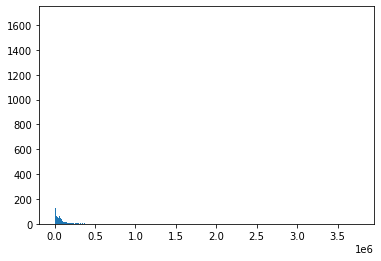

In [99]:
plt.hist([sum(c) for c in counts], bins=1000)

(array([1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 3.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        4.000e+00, 5.000e+00, 7.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        5.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 5.000e+00,
        4.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 8.000e+00, 0.000e+00,
        4.000e+00, 7.000e+00, 7.000e+00, 3.000e+00, 7.000e+00, 9.000e+00,
        7.000e+00, 8.000e+00, 5.000e+00, 8.000e+00, 1.000e+01, 6.000e+00,
        7.000e+00, 4.000e+00, 5.000e+00, 5.000e+00, 5.000e+00, 1.300e+01,
        1.700e+01, 1.000e+01, 2.000e+01, 2.000e+01, 2.500e+01, 2.700e+01,
        2.000e+01, 2.300e+01, 2.800e+01, 2.700e+01, 1.800e+01, 2.100e+01,
        2.000e+01, 2.100e+01, 1.300e+01, 2.900e+01, 1.300e+01, 2.500e+01,
        1.800e+01, 1.800e+01, 2.700e+0

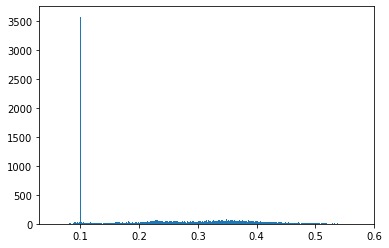

In [103]:
plt.hist(metrics[metrics.step == 86].test_accuracy, bins=1000)